Adding the necessary libraries

In [2]:
# import the library we use to open URLs
import urllib.request
import pandas as pd
import numpy as np 

import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

Foursquare parameters

In [3]:
CLIENT_ID = 'JVNBNAH55QX2VQNO5DKDMFZ5UDR1CDTCSDGZCPAD05PYMVMV' # your Foursquare ID
CLIENT_SECRET = 'LWKFC3QZJDVBDW04VP3WDTJDK3E452VAZWIZR4IKDAPDU33H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Load popoulation data for Brussels neighborhoods

In [4]:
path = 'F:\Data\Brussels6.csv'
my_data = pd.read_csv(path, delimiter=";")
my_data.rename(columns = {'Population Estimate 2019-01-01':'Population2019'}, inplace = True) 
my_data.head()

,Name,Status,Population Estimate 1990-01-01,Population Estimate 1995-01-01,Population Estimate 2000-01-01,Population Estimate 2005-01-01,Population Estimate 2010-01-01,Population Estimate 2015-01-01,Population2019,Latitude,Longitude
0,Anderlecht,Municipality,89231,87920,87812,93808,104647,116332,119714,50.842989,4.329696
1,Auderghem (Oudergem),Municipality,29143,29316,28804,29265,30811,32835,34013,50.808369,4.420675
2,Berchem-Sainte-Agathe (Sint-Agatha-Berchem),Municipality,18566,18653,18735,19968,22185,23927,25179,50.867495,4.292965
3,Bruxelles (Brussel) [Brussels],Municipality,136706,135681,133859,142853,157673,175534,181726,50.861350,4.359934
4,Etterbeek,Municipality,39641,38727,39404,41097,44352,46773,48367,50.838881,4.390485


In [5]:
Brussels_data = my_data.drop(['Status','Population Estimate 1990-01-01','Population Estimate 1995-01-01','Population Estimate 2000-01-01','Population Estimate 2005-01-01','Population Estimate 2010-01-01','Population Estimate 2015-01-01'], axis=1)
#del my_data
Brussels_data.head(20)

,Name,Population2019,Latitude,Longitude
0,Anderlecht,119714,50.842989,4.329696
1,Auderghem (Oudergem),34013,50.808369,4.420675
2,Berchem-Sainte-Agathe (Sint-Agatha-Berchem),25179,50.867495,4.292965
3,Bruxelles (Brussel) [Brussels],181726,50.861350,4.359934
4,Etterbeek,48367,50.838881,4.390485
5,Evere,41763,50.864549,4.400135
6,Forest (Vorst),56289,50.810635,4.324910
7,Ganshoren,24902,50.869363,4.312332
8,Ixelles (Elsene),86876,50.835549,4.366051
9,Jette,52536,50.877103,4.327729


Plot neighborhoods on map

In [6]:
# create map of New York using latitude and longitude values
latitude = 50.8549541
longitude = 4.3553508
map_brussels= folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, Name in zip(Brussels_data['Latitude'], Brussels_data['Longitude'], Brussels_data['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brussels)  
    
map_brussels

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&categoryId=4d4b7105d754a06374d81259&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# type your answer here
Brussels_venues = getNearbyVenues(names=Brussels_data['Name'],
                                   latitudes=Brussels_data['Latitude'],
                                   longitudes=Brussels_data['Longitude']
                                  )
Brussels_venues.head()

Anderlecht
Auderghem (Oudergem)
Berchem-Sainte-Agathe (Sint-Agatha-Berchem)
Bruxelles (Brussel) [Brussels]
Etterbeek
Evere
Forest (Vorst)
Ganshoren
Ixelles (Elsene)
Jette
Koekelberg
Molenbeek-Saint-Jean (Sint-Jans-Molenbeek)
Saint-Gilles (Sint-Gillis)
Saint-Josse-ten-Noode (Sint-Joost-ten-Node)
Schaerbeek (Schaarbeek)
Uccle (Ukkel)
Watermael-Boitsfort (Watermaal-Bosvoorde)
Woluwe-Saint-Lambert (Sint-Lambrechts-Woluwe)
Woluwe-Saint-Pierre (Sint-Pieters-Woluwe)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anderlecht,50.842989,4.329696,La Paix,50.843592,4.328049,French Restaurant
1,Anderlecht,50.842989,4.329696,Foodmet,50.842434,4.329135,Food Court
2,Anderlecht,50.842989,4.329696,Bab Al Hara,50.843854,4.335431,Snack Place
3,Anderlecht,50.842989,4.329696,Abattoir d'Anderlecht / Slachthuis van Anderle...,50.843264,4.327476,Food Court
4,Anderlecht,50.842989,4.329696,Maharaja Tandoori Restaurant I,50.839015,4.332212,Indian Restaurant


In [10]:
# one hot encoding
brussels_onehot = pd.get_dummies(Brussels_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brussels_onehot['Neighborhood'] = Brussels_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brussels_onehot.columns[-1]] + list(brussels_onehot.columns[:-1])
brussels_onehot = brussels_onehot[fixed_columns]

brussels_onehot

,Neighborhood,African Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brasserie,Brazilian Restaurant,...,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
brussels_grouped = brussels_onehot.groupby('Neighborhood').mean().reset_index()

In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brussels_grouped['Neighborhood']

for ind in np.arange(brussels_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brussels_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,Food Court,Lebanese Restaurant,Indian Restaurant,Steakhouse,Restaurant,Sandwich Place,Snack Place,Deli / Bodega,Italian Restaurant,French Restaurant
1,Auderghem (Oudergem),Italian Restaurant,Bakery,Sandwich Place,Bistro,Snack Place,Wings Joint,Fast Food Restaurant,Doner Restaurant,Eastern European Restaurant,Egyptian Restaurant
2,Berchem-Sainte-Agathe (Sint-Agatha-Berchem),Snack Place,Greek Restaurant,Bakery,Sandwich Place,Buffet,Fast Food Restaurant,Diner,Deli / Bodega,Pizza Place,Restaurant
3,Bruxelles (Brussel) [Brussels],Sandwich Place,Snack Place,Italian Restaurant,Bakery,Thai Restaurant,Doner Restaurant,Kebab Restaurant,Gastropub,Egyptian Restaurant,Chinese Restaurant
4,Etterbeek,Pizza Place,Greek Restaurant,Italian Restaurant,Bakery,Brasserie,Sandwich Place,Japanese Restaurant,Kebab Restaurant,Eastern European Restaurant,Diner


In [14]:
brussels_grouped_clustering = brussels_grouped.drop(['Neighborhood'], 1)

Find the proper K for K-means algorithm

In [18]:
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(brussels_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

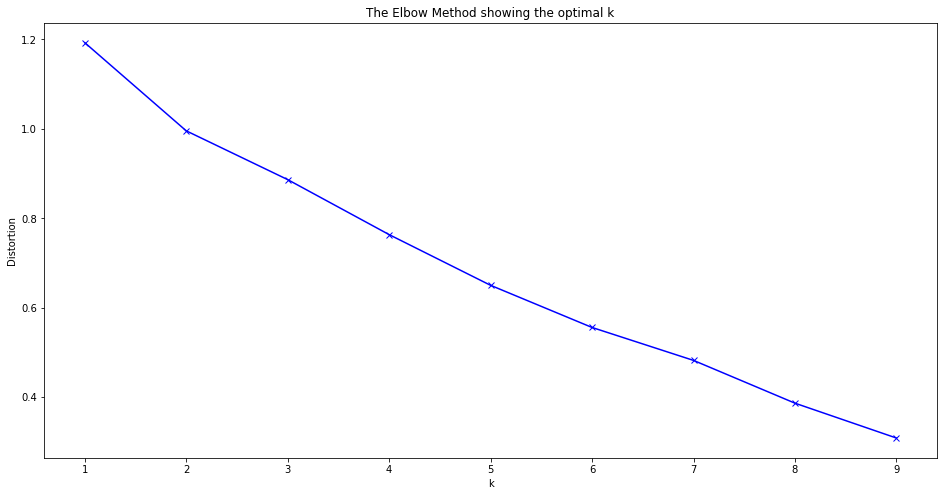

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
# set number of clusters
kclusters = 4


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brussels_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [20]:


brussels_merged = Brussels_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brussels_merged = brussels_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

brussels_merged.head() # check the last columns!

,Name,Population2019,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,119714,50.842989,4.329696,0,Food Court,Lebanese Restaurant,Indian Restaurant,Steakhouse,Restaurant,Sandwich Place,Snack Place,Deli / Bodega,Italian Restaurant,French Restaurant
1,Auderghem (Oudergem),34013,50.808369,4.420675,0,Italian Restaurant,Bakery,Sandwich Place,Bistro,Snack Place,Wings Joint,Fast Food Restaurant,Doner Restaurant,Eastern European Restaurant,Egyptian Restaurant
2,Berchem-Sainte-Agathe (Sint-Agatha-Berchem),25179,50.867495,4.292965,1,Snack Place,Greek Restaurant,Bakery,Sandwich Place,Buffet,Fast Food Restaurant,Diner,Deli / Bodega,Pizza Place,Restaurant
3,Bruxelles (Brussel) [Brussels],181726,50.861350,4.359934,0,Sandwich Place,Snack Place,Italian Restaurant,Bakery,Thai Restaurant,Doner Restaurant,Kebab Restaurant,Gastropub,Egyptian Restaurant,Chinese Restaurant
4,Etterbeek,48367,50.838881,4.390485,1,Pizza Place,Greek Restaurant,Italian Restaurant,Bakery,Brasserie,Sandwich Place,Japanese Restaurant,Kebab Restaurant,Eastern European Restaurant,Diner


Plot clustered neighborhoods on map and also the top 5 butcher shops

In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brussels_merged['Latitude'], brussels_merged['Longitude'], brussels_merged['Name'], brussels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    label = "Jack O’Shea"
    folium.CircleMarker(
        [50.849979,4.347678],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    label = "Maison Segers"
    folium.CircleMarker(
        [50.832941,4.3512275],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    label = "Coprosain"
    folium.CircleMarker(
        [50.6806482,4.3675318],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    label = "Maison Lanssens"
    folium.CircleMarker(
        [50.840356,4.3988793],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    label = "Le Petit Normand"
    folium.CircleMarker(
        [50.848106,4.3494923],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    
    
map_clusters

As there are plenty of Greek restaurants on Segment 1 we recommend the first "Leonidas place" to be located on a cluster 1 area. Since there are two very good butcher shops and the population is big on Molenbeek we recommend that the shop should open on Molenbeek area.

In [22]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 1, brussels_merged.columns[[0,1] + list(range(5, brussels_merged.shape[1]))]]

,Name,Population2019,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Berchem-Sainte-Agathe (Sint-Agatha-Berchem),25179,Snack Place,Greek Restaurant,Bakery,Sandwich Place,Buffet,Fast Food Restaurant,Diner,Deli / Bodega,Pizza Place,Restaurant
4,Etterbeek,48367,Pizza Place,Greek Restaurant,Italian Restaurant,Bakery,Brasserie,Sandwich Place,Japanese Restaurant,Kebab Restaurant,Eastern European Restaurant,Diner
6,Forest (Vorst),56289,Pizza Place,Chinese Restaurant,Steakhouse,Halal Restaurant,French Restaurant,Middle Eastern Restaurant,Sandwich Place,Friterie,Bistro,Brasserie
7,Ganshoren,24902,Burger Joint,Pizza Place,Snack Place,Italian Restaurant,Friterie,Bakery,Sandwich Place,Chinese Restaurant,Café,Restaurant
9,Jette,52536,Snack Place,Bakery,Pizza Place,Gastropub,Italian Restaurant,Belgian Restaurant,Deli / Bodega,Chinese Restaurant,Burger Joint,Restaurant
11,Molenbeek-Saint-Jean (Sint-Jans-Molenbeek),97462,Pizza Place,French Restaurant,Italian Restaurant,Burger Joint,Sandwich Place,Seafood Restaurant,Japanese Restaurant,Moroccan Restaurant,Breakfast Spot,Snack Place
12,Saint-Gilles (Sint-Gillis),50267,Pizza Place,Brasserie,Moroccan Restaurant,Italian Restaurant,French Restaurant,Portuguese Restaurant,Friterie,Latin American Restaurant,Bakery,Belgian Restaurant
14,Schaerbeek (Schaarbeek),133309,Snack Place,Turkish Restaurant,French Restaurant,Pizza Place,Gastropub,Spanish Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Italian Restaurant,Falafel Restaurant
16,Watermael-Boitsfort (Watermaal-Bosvoorde),25184,French Restaurant,Indian Restaurant,Belgian Restaurant,Fast Food Restaurant,Salad Place,Brasserie,Restaurant,Bakery,Asian Restaurant,Bistro


In [23]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 0, brussels_merged.columns[[0,1] + list(range(5, brussels_merged.shape[1]))]]

,Name,Population2019,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,119714,Food Court,Lebanese Restaurant,Indian Restaurant,Steakhouse,Restaurant,Sandwich Place,Snack Place,Deli / Bodega,Italian Restaurant,French Restaurant
1,Auderghem (Oudergem),34013,Italian Restaurant,Bakery,Sandwich Place,Bistro,Snack Place,Wings Joint,Fast Food Restaurant,Doner Restaurant,Eastern European Restaurant,Egyptian Restaurant
3,Bruxelles (Brussel) [Brussels],181726,Sandwich Place,Snack Place,Italian Restaurant,Bakery,Thai Restaurant,Doner Restaurant,Kebab Restaurant,Gastropub,Egyptian Restaurant,Chinese Restaurant
8,Ixelles (Elsene),86876,Italian Restaurant,Sandwich Place,Thai Restaurant,Café,Mediterranean Restaurant,Restaurant,African Restaurant,Snack Place,French Restaurant,Fried Chicken Joint
10,Koekelberg,21990,Italian Restaurant,Restaurant,Greek Restaurant,Snack Place,Chinese Restaurant,Doner Restaurant,Sandwich Place,Falafel Restaurant,Indonesian Restaurant,French Restaurant
13,Saint-Josse-ten-Noode (Sint-Joost-ten-Node),27457,Italian Restaurant,Sandwich Place,Restaurant,Thai Restaurant,Snack Place,Belgian Restaurant,African Restaurant,Salad Place,Japanese Restaurant,Middle Eastern Restaurant
15,Uccle (Ukkel),83024,Sandwich Place,Bakery,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Pizza Place,Restaurant,Snack Place,Moroccan Restaurant,French Restaurant
18,Woluwe-Saint-Pierre (Sint-Pieters-Woluwe),41824,Italian Restaurant,Restaurant,French Restaurant,Fast Food Restaurant,Sandwich Place,Greek Restaurant,Burger Joint,Pizza Place,Cafeteria,Diner


In [24]:
brussels_merged.loc[brussels_merged['Cluster Labels'] == 3, brussels_merged.columns[[0,1] + list(range(5, brussels_merged.shape[1]))]]

,Name,Population2019,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Woluwe-Saint-Lambert (Sint-Lambrechts-Woluwe),56660,Italian Restaurant,Sandwich Place,Food Truck,Burger Joint,Wings Joint,Falafel Restaurant,Doner Restaurant,Eastern European Restaurant,Egyptian Restaurant,Fish & Chips Shop
